In [1]:
# Wczytanie bibliotek

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from datetime import datetime
from keras.callbacks import TensorBoard
from sklearn.metrics import classification_report

import os
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from sklearn import tree
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import warnings
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import joblib

In [2]:
### Wczytanie bazy danych

train_dataset_fp  = pd.read_csv('C:/wikiart/prediction_set_genre.csv')
train_dataset_fp = train_dataset_fp.drop(['Unnamed: 0'], axis=1)

In [3]:
# Zakodowanie i sprawdzenie klas i kategorii

column_names = train_dataset_fp.columns

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

names = train_dataset_fp[label_name]

Features: Index(['Ekspresjonizm Abstrakcyjny', 'Taszyzm', 'Kubizm Analityczny',
       'Art Noveau', 'Barok', 'Malarstwo Barwnych Płaszczyzn',
       'Realizm Współczesny', 'Kubizm', 'Wczesny Renesans', 'Ekspresjonizm',
       'Fowizm', 'Wysoki Renesans', 'Impresjonizm', 'Późny Renesans',
       'Minimalizm', 'Prymitywizm', 'Nowy Realizm', 'Północny Renesans',
       'Puentylizm', 'Pop Art', 'Postimpresjonizm', 'Realizm', 'Rokoko',
       'Romantyzm', 'Symbolizm', 'Kubizm Syntetyczny', 'Ukiyo-e', 'Abstrakcja',
       'Pejzaż Miejski', 'Malarstwo Rodzajowe', 'Ilustracja', 'Krajobraz',
       'Akt', 'Portret', 'Malarstwo Religijne', 'Szkic', 'Martwa Natura',
       'albrecht-durer', 'alfred-sisley', 'amedeo-modigliani',
       'boris-kustodiev', 'camille-corot', 'camille-pissarro', 'childe-hassam',
       'claude-monet', 'david-burliuk', 'edgar-degas', 'egon-schiele',
       'ernst-ludwig-kirchner', 'eugene-boudin', 'ferdinand-hodler',
       'fernand-leger', 'francisco-goya', 'georges-b

In [4]:
# Liczebność klas

classes = ['Abstrakcja', 'Pejzaż Miejski', 'Malarstwo Rodzajowe', 'Ilustracja', 'Krajobraz', 'Akt', 'Portret', 'Malarstwo Religijne', 'Szkic', 'Martwa Natura']
dataset_count = train_dataset_fp.groupby(['Genre']).size().reset_index(name='count')

In [5]:
# Zakodowanie klas docelowych w postać liczbową

train_dataset_fp['Genre'] = pd.Categorical(train_dataset_fp['Genre'])
train_dataset_fp['Genre'] = train_dataset_fp.Genre.cat.codes

In [6]:
# Dodanie ścieżek

df_mini = pd.read_csv('C:/MAG/df2/df_mini.csv')
train_dataset_fp['file'] = df_mini['file']

In [7]:
# Określenie które obrazy są w zbiorze treningowym

train_choice = pd.read_csv('C:/MAG/df2/train_genre_togo.csv')
train_set =  train_dataset_fp[train_dataset_fp['file'].isin(train_choice['file'])]
train_set = train_set.drop(['file'], axis=1)

In [8]:
# Liczebność klas zbioru treningowego

train_count = train_choice.groupby(['Genre_name_x']).size().reset_index(name='count')
train_count

,Genre_name_x,count
0,Abstrakcja,193
1,Akt,319
2,Ilustracja,91
3,Krajobraz,2752
4,Malarstwo Religijne,648
5,Malarstwo Rodzajowe,1761
6,Martwa Natura,563
7,Pejzaż Miejski,803
8,Portret,2386
9,Szkic,949


In [9]:
# Przygotowanie X i y zbioru treningowego

X = train_set[feature_names]
y = train_set['Genre']

enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train = X_scaled
Y_train = y
Y_trainNN = Y

<ipython-input-9-6af332d8a104>:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y = enc.fit_transform(y[:, np.newaxis]).toarray()


In [10]:
# Określenie które obrazy są w zbiorze testowo-walidacyjnym
# (ze względu na małą liczebność niektórych klas, zbiory te zostały połączone)

test_choice = pd.read_csv('C:/MAG/df2/test_genre_togo.csv')
val_choice = pd.read_csv('C:/MAG/df2/val_genre_togo.csv')
test_choice = pd.concat([test_choice,val_choice])

test_set =  train_dataset_fp[train_dataset_fp['file'].isin(test_choice['file'])]
test_set = test_set.drop(['file'], axis=1)

In [11]:
# Liczebność klas zbioru testowo-walidacyjnego

test_count = test_choice.groupby(['Genre_name_x']).size().reset_index(name='count')
test_count

,Genre_name_x,count
0,Abstrakcja,77
1,Akt,129
2,Ilustracja,33
3,Krajobraz,1110
4,Malarstwo Religijne,261
5,Malarstwo Rodzajowe,640
6,Martwa Natura,228
7,Pejzaż Miejski,284
8,Portret,904
9,Szkic,367


In [12]:
# Przygotowanie X i y zbioru testowo-walidacyjnego

X = test_set[feature_names]
y = test_set['Genre']

enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_test = X_scaled
Y_test = y
Y_testNN = Y

<ipython-input-12-e6d1c1462f4d>:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y = enc.fit_transform(y[:, np.newaxis]).toarray()


In [13]:
# Parametry klasyfikacji

n_features = X.shape[1]
n_classes = Y.shape[1]
test_count = Y_test.groupby(y).size().reset_index(name='count')

In [14]:
# Funkcja generująca raport klasyfikacji (po polsku)

def cmtable(y_test_cls,test_pred):
    report = classification_report(y_test_cls, test_pred,target_names=classes,output_dict=True)
    raport = pd.DataFrame(report).transpose()
    raport2 = raport.rename(columns={'Precyzja  \n(precision)': 'precision','Czułość \n(recall)': 'recall', 'F1': 'f1-score', 'Liczba obrazów \n(support)': 'support'}, index={'Dokładność': 'accuracy'})
    raport.columns = ['Precyzja  \n(precision)','Czułość \n(recall)','F1','Liczba obrazów \n(support)']
    mapping = {raport.index[len(test_count)]:'Dokładność \n(accuracy)', raport.index[len(test_count)+1]: 'Średnia', raport.index[len(test_count)+2]:'Średnia ważona'}
    raport = raport.rename(index=mapping)
    raport = raport.round(2)

    raport.iloc[len(test_count)][3] = raport.iloc[len(test_count)+1][3]

    raport['Liczba obrazów \n(support)'] = raport['Liczba obrazów \n(support)'].astype(int)
    raport = raport.astype({"Precyzja  \n(precision)": str, "Czułość \n(recall)": str})
    
    raport['Precyzja  \n(precision)']['Dokładność \n(accuracy)'] = None
    raport['Czułość \n(recall)']['Dokładność \n(accuracy)'] = None
    name = raport.iloc[[len(test_count),len(test_count)+1,len(test_count)+2],:] 
    return(name)

In [15]:
# Klasyfikator - Regresja Logistyczna

LR = LogisticRegression(random_state=0, solver='lbfgs',max_iter=1500, multi_class='multinomial').fit(X_train, Y_train)
LR_pred = LR.predict(X_test)
round(LR.score(X_test,Y_test), 4)

0.7134

In [16]:
# Klasyfikator - Support Vector Machine (Maszyna wektorów nośnych)

SVM = svm.SVC(decision_function_shape="ovo").fit(X_train, Y_train)
SVM_pred = SVM.predict(X_test)
round(SVM.score(X_test, Y_test), 4)

0.7059

In [17]:
# Klasyfikator - Las losowy

RF = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=0).fit(X_train, Y_train)
RF_pred = RF.predict(X_test)
round(RF.score(X_test, Y_test), 4)

0.7057

In [18]:
# Klasyfikator - Perceptron wielowarstwowy

NN = MLPClassifier(solver='lbfgs',max_iter=1500, alpha=1e-5, hidden_layer_sizes=(200, 20), random_state=1).fit(X_train, Y_train)
NN_pred = NN.predict(X_test)
round(NN.score(X_test, Y_test), 4)

0.7183

In [19]:
# Raport - Regresja Logistyczna

print(classification_report(Y_test, LR_pred,target_names=classes))

                     precision    recall  f1-score   support

         Abstrakcja       0.66      0.90      0.76        77
     Pejzaż Miejski       0.64      0.60      0.62       284
Malarstwo Rodzajowe       0.53      0.53      0.53       640
         Ilustracja       0.34      0.61      0.43        33
          Krajobraz       0.80      0.86      0.83      1110
                Akt       0.67      0.53      0.59       129
            Portret       0.82      0.80      0.81       904
Malarstwo Religijne       0.60      0.51      0.55       261
              Szkic       0.70      0.63      0.66       367
      Martwa Natura       0.72      0.75      0.73       228

           accuracy                           0.71      4033
          macro avg       0.65      0.67      0.65      4033
       weighted avg       0.71      0.71      0.71      4033



In [20]:
# Raport - SVM

print(classification_report(Y_test, SVM_pred))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89        77
           1       0.63      0.60      0.61       284
           2       0.52      0.54      0.53       640
           3       0.33      0.48      0.40        33
           4       0.80      0.85      0.82      1110
           5       0.67      0.52      0.59       129
           6       0.76      0.79      0.78       904
           7       0.63      0.49      0.55       261
           8       0.69      0.61      0.65       367
           9       0.72      0.73      0.73       228

    accuracy                           0.71      4033
   macro avg       0.67      0.65      0.65      4033
weighted avg       0.70      0.71      0.70      4033



In [21]:
# Raport - Las Losowy

print(classification_report(Y_test, RF_pred,target_names=classes))

                     precision    recall  f1-score   support

         Abstrakcja       0.60      0.90      0.72        77
     Pejzaż Miejski       0.60      0.60      0.60       284
Malarstwo Rodzajowe       0.53      0.53      0.53       640
         Ilustracja       0.34      0.61      0.44        33
          Krajobraz       0.81      0.85      0.83      1110
                Akt       0.67      0.53      0.59       129
            Portret       0.81      0.79      0.80       904
Malarstwo Religijne       0.59      0.49      0.54       261
              Szkic       0.69      0.61      0.65       367
      Martwa Natura       0.71      0.74      0.72       228

           accuracy                           0.71      4033
          macro avg       0.63      0.66      0.64      4033
       weighted avg       0.71      0.71      0.70      4033



In [22]:
# Raport - Perceptron Wielowarstwowy

print(classification_report(Y_test, NN_pred,target_names=classes))

                     precision    recall  f1-score   support

         Abstrakcja       0.77      0.94      0.84        77
     Pejzaż Miejski       0.60      0.63      0.62       284
Malarstwo Rodzajowe       0.55      0.53      0.54       640
         Ilustracja       0.34      0.61      0.44        33
          Krajobraz       0.81      0.85      0.83      1110
                Akt       0.61      0.53      0.57       129
            Portret       0.82      0.80      0.81       904
Malarstwo Religijne       0.61      0.55      0.58       261
              Szkic       0.70      0.63      0.66       367
      Martwa Natura       0.73      0.76      0.74       228

           accuracy                           0.72      4033
          macro avg       0.65      0.68      0.66      4033
       weighted avg       0.72      0.72      0.72      4033



In [23]:
# Raporty razem (po polsku do pracy)
regresja = cmtable(Y_test, LR_pred)
svm = cmtable(Y_test, SVM_pred)
las = cmtable(Y_test, RF_pred)
perceptron = cmtable(Y_test, NN_pred)

klasyfikatory = pd.concat([regresja,svm,las,perceptron])
klasyfikatory.to_excel('C:/MAG/excelki sieci wyzszych/gatunku/klasyfikatory.xlsx')

<ipython-input-14-50de86c8b6b8>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raport['Precyzja  \n(precision)']['Dokładność \n(accuracy)'] = None
<ipython-input-14-50de86c8b6b8>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raport['Czułość \n(recall)']['Dokładność \n(accuracy)'] = None
<ipython-input-14-50de86c8b6b8>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raport['Precyzja  \n(precision)']['Dokładność \n(accuracy)'] =

In [24]:
# Zapisanie najlepszego klasyfikatora

joblib.dump(LR,'C:/MAG/Gatunek_wyzszy/LR.joblib')

['C:/MAG/Gatunek_wyzszy/LR.joblib']

In [25]:
# Tworzenie modeli sieci neuronowych

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

def create_custom_model(input_dim, output_dim, nodes, n=1, name='model'):
    def create_model():
        model = Sequential(name=name)
        for i in range(n):
            model.add(Dense(nodes, input_dim=input_dim, activation='relu'))
        model.add(Dense(output_dim, activation='softmax'))

        model.compile(loss='categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])
        return model
    return create_model

models = [create_custom_model(n_features, n_classes, 8, i, 'model_{}'.format(i)) 
          for i in range(1, 4)]

for create_model in models:
    create_model().summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 800       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                90        
Total params: 890
Trainable params: 890
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 800       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                90        
Total params: 962
Trainable params: 962
Non-

In [26]:
# Tensorboard
%load_ext tensorboard
logdir = "logs/siec_wyzsza/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir)

In [27]:
# Szkolenie sieci

history_dict = {}

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
i=0

for create_model in models:
    model = create_model()
    print('Model name:', model.name)
    
    logdir = "logs/siec_wyzsza/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    file_writer = tf.summary.create_file_writer(logdir)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

    history_callback = model.fit(X_train, Y_trainNN,
                                 batch_size=8,
                                 epochs=25,
                                 verbose=0,
                                 validation_data=(X_test, Y_testNN),
                                 callbacks=[tensorboard_callback])
    score = model.evaluate(X_test, Y_testNN, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    test_pred_raw = model.predict(X_test)
    test_pred = np.argmax(test_pred_raw, axis=1)
    y_test_cls = np.argmax(Y_testNN, axis=1)
    print(classification_report(y_test_cls, test_pred,target_names=classes))
    nazwa = model.name
    cmtable(y_test_cls, test_pred).to_excel('C:/MAG/excelki sieci wyzszych/gatunku/'+nazwa+'.xlsx')
    model.save('C:/MAG/Gatunek_wyzszy/'+nazwa+'.hdf5') 
    history_dict[model.name] = [history_callback, model]

Model name: model_1
Test loss: 6.397458553314209
Test accuracy: 0.7061740756034851
                     precision    recall  f1-score   support

         Abstrakcja       0.58      0.88      0.70        77
     Pejzaż Miejski       0.63      0.61      0.62       284
Malarstwo Rodzajowe       0.53      0.52      0.52       640
         Ilustracja       0.32      0.61      0.42        33
          Krajobraz       0.81      0.85      0.83      1110
                Akt       0.58      0.54      0.56       129
            Portret       0.82      0.79      0.81       904
Malarstwo Religijne       0.61      0.51      0.55       261
              Szkic       0.69      0.62      0.65       367
      Martwa Natura       0.70      0.75      0.72       228

           accuracy                           0.71      4033
          macro avg       0.63      0.67      0.64      4033
       weighted avg       0.71      0.71      0.71      4033



<ipython-input-14-50de86c8b6b8>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raport['Precyzja  \n(precision)']['Dokładność \n(accuracy)'] = None
<ipython-input-14-50de86c8b6b8>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raport['Czułość \n(recall)']['Dokładność \n(accuracy)'] = None


Model name: model_2
Test loss: 10.296419143676758
Test accuracy: 0.7004711031913757
                     precision    recall  f1-score   support

         Abstrakcja       0.57      0.88      0.69        77
     Pejzaż Miejski       0.60      0.60      0.60       284
Malarstwo Rodzajowe       0.52      0.52      0.52       640
         Ilustracja       0.24      0.58      0.34        33
          Krajobraz       0.81      0.85      0.83      1110
                Akt       0.66      0.53      0.59       129
            Portret       0.83      0.78      0.80       904
Malarstwo Religijne       0.56      0.51      0.53       261
              Szkic       0.69      0.62      0.65       367
      Martwa Natura       0.70      0.75      0.73       228

           accuracy                           0.70      4033
          macro avg       0.62      0.66      0.63      4033
       weighted avg       0.71      0.70      0.70      4033



<ipython-input-14-50de86c8b6b8>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raport['Precyzja  \n(precision)']['Dokładność \n(accuracy)'] = None
<ipython-input-14-50de86c8b6b8>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raport['Czułość \n(recall)']['Dokładność \n(accuracy)'] = None


Model name: model_3
Test loss: 11.741559028625488
Test accuracy: 0.698983371257782
                     precision    recall  f1-score   support

         Abstrakcja       0.57      0.90      0.69        77
     Pejzaż Miejski       0.61      0.59      0.60       284
Malarstwo Rodzajowe       0.53      0.50      0.51       640
         Ilustracja       0.22      0.58      0.32        33
          Krajobraz       0.80      0.85      0.83      1110
                Akt       0.52      0.54      0.53       129
            Portret       0.83      0.78      0.80       904
Malarstwo Religijne       0.59      0.50      0.54       261
              Szkic       0.70      0.61      0.65       367
      Martwa Natura       0.71      0.75      0.73       228

           accuracy                           0.70      4033
          macro avg       0.61      0.66      0.62      4033
       weighted avg       0.70      0.70      0.70      4033



<ipython-input-14-50de86c8b6b8>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raport['Precyzja  \n(precision)']['Dokładność \n(accuracy)'] = None
<ipython-input-14-50de86c8b6b8>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raport['Czułość \n(recall)']['Dokładność \n(accuracy)'] = None


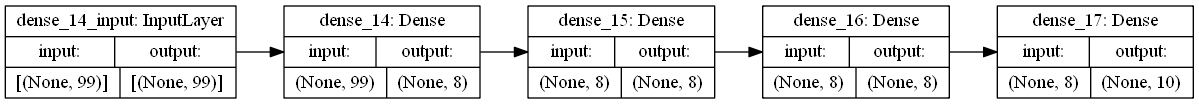

In [28]:
# Wyplotowanie ostatniego z modeli

tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")